In [149]:
import pandas as pd
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('white')

In [166]:
data = pd.read_csv('bandoro-microbiome.csv')
# data['Sample'] = data['Sample'].astype('category')

# Encode the "Sample" column with indices.
# sample_names = dict(list(set((val, i) for i, val in enumerate(sorted(data['Sample'].values)))))
sample_names = dict()
for i, name in enumerate(list(np.unique(data['Sample'].values))):
    sample_names[name] = i
for name, i in sample_names.items():
    print(i, name)
    data['Indices'] = data['Sample'].apply(lambda x: sample_names[x])
data.head(10)

# # Encode the "date" column with indices.
# date_names = sorted(list(set(data['Date'].values)))
# for i, name in enumerate(date_names):
#     print(i, name)
#     data['Date'] = data['Date'].replace(name, i)
# data.head(10)

2 Bacteroides ovatus 
6 Escherichia coli BC15
12 Salmonella typhimurium 
13 Water
9 Parabacteroides distastonis 
4 Bacteroides vulgatus
10 Pseudomonas aeruginosa 
0 Akkermansia muciniphilia 
8 Eubacterium rectale 
1 Bacteroides fragilis 
3 Bacteroides thetaiotaomicron 
5 Clostridium scindens 
7 Escherichia coli K12
11 Rumincoccus obeum 


,Date,Sample,% GFP,Normalized % GFP,Replicate,Indices
0,09.03.2016,Water,15.90,98.148148,1,13
1,09.03.2016,Water,16.50,101.851852,2,13
2,08.31.2016,Water,26.00,108.559499,3,13
3,08.31.2016,Water,21.90,91.440501,4,13
4,09.03.2016,Salmonella typhimurium,1.84,11.358025,1,12
5,09.03.2016,Salmonella typhimurium,2.01,12.407407,2,12
6,08.31.2016,Salmonella typhimurium,6.49,27.098121,3,12
7,08.31.2016,Salmonella typhimurium,5.82,24.300626,4,12
8,09.03.2016,Rumincoccus obeum,9.59,59.197531,1,11
9,09.03.2016,Rumincoccus obeum,7.73,47.716049,2,11


In [168]:
with pm.Model() as model:
    # Hyperpriors
    upper = pm.Exponential('upper', lam=0.05)
    # lower = pm.Exponential('lower', lam=1)

    # "fold", which is the estimated fold change.
    fold = pm.Uniform('fold', lower=1E-10, upper=upper, shape=len(sample_names))

    # Assume that data have heteroskedastic (i.e. variable) error but are drawn from the same distribution
    # sigma = pm.Gamma('sigma', alpha=1, beta=1, shape=n_genotypes+2)
    sigma = pm.HalfCauchy('sigma', beta=1, shape=len(sample_names))

    # Model prediction
    mu = fold[data['Indices']]
    sig = sigma[data['Indices']]

    # Data likelihood
    like = pm.Normal('like', mu=mu, sd=sig, observed=data['Normalized % GFP'])

Applied log-transform to upper and added transformed upper_log_ to model.
Applied interval-transform to fold and added transformed fold_interval_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [169]:
with model:
    n_steps = 300000
    params = pm.variational.advi(n=n_steps)
    trace = pm.variational.sample_vp(params, draws=2000)


Iteration 0 [0%]: ELBO = -183283.36
Iteration 30000 [10%]: Average ELBO = -30404.86
Iteration 60000 [20%]: Average ELBO = -283.08
Iteration 90000 [30%]: Average ELBO = -280.58
Iteration 120000 [40%]: Average ELBO = -280.02
Iteration 150000 [50%]: Average ELBO = -279.96
Iteration 180000 [60%]: Average ELBO = -279.98
Iteration 210000 [70%]: Average ELBO = -279.94
Iteration 240000 [80%]: Average ELBO = -280.02
Iteration 270000 [90%]: Average ELBO = -280.07
Finished [100%]: Average ELBO = -279.92


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1336c8fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x133f48240>]], dtype=object)

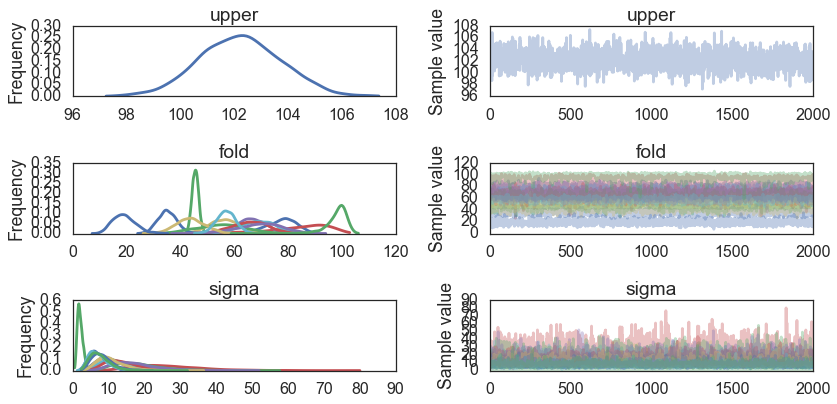

In [170]:
pm.traceplot(trace)

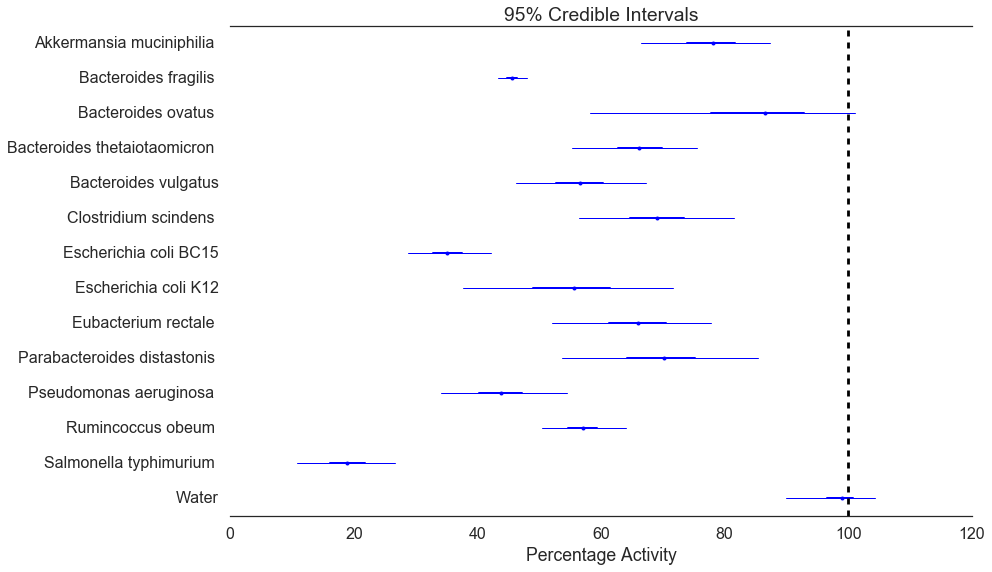

In [226]:
fig = plt.figure(figsize=(20, 8))
pm.forestplot(trace, varnames=['fold'], vline=100, ylabels=sorted(sample_names), xtitle='Percentage Activity', xrange=(0, 120))
plt.savefig('../figures/bandoro-microbiome-bayes.pdf', bbox_inches='tight')

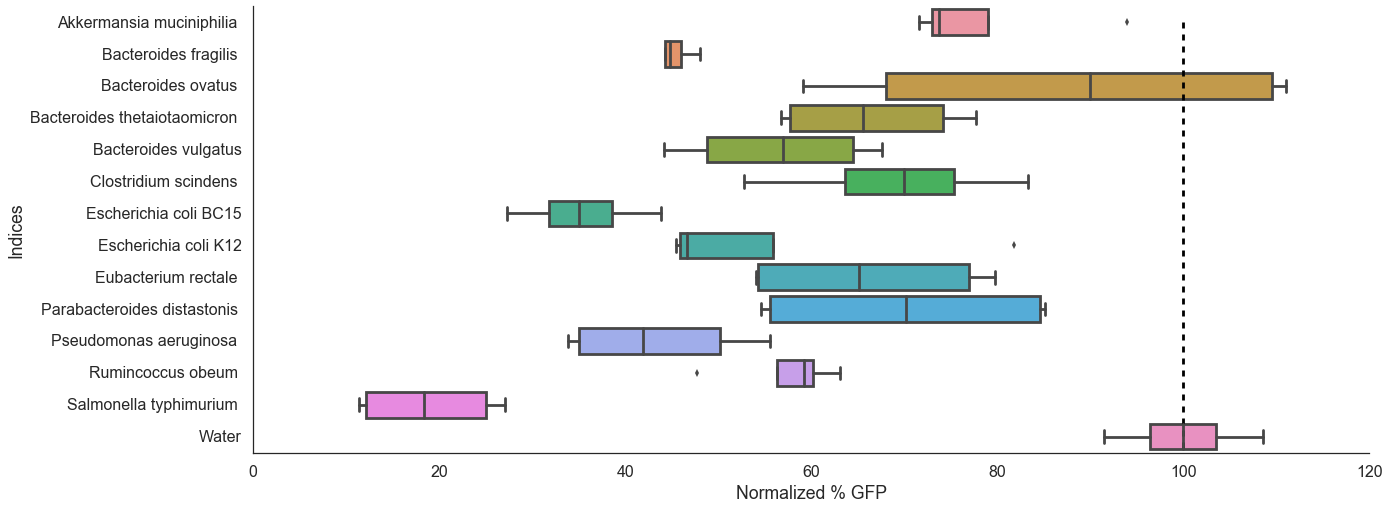

In [258]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
# data.plot(kind='scatter', y='Normalized % GFP', x='Indices', ax=ax)
# data.boxplot(column='Normalized % GFP', by='Indices', ax=ax)
sns.boxplot(data=data, y='Indices', x='Normalized % GFP', orient='h')
plt.yticks(range(len(sample_names)), sorted(sample_names))
ax.vlines(x=100, ymin=0, ymax=len(sample_names), linestyle='--')
sns.despine()
plt.savefig('../figures/bandoro-microbiome-data.pdf', bbox_inches='tight')

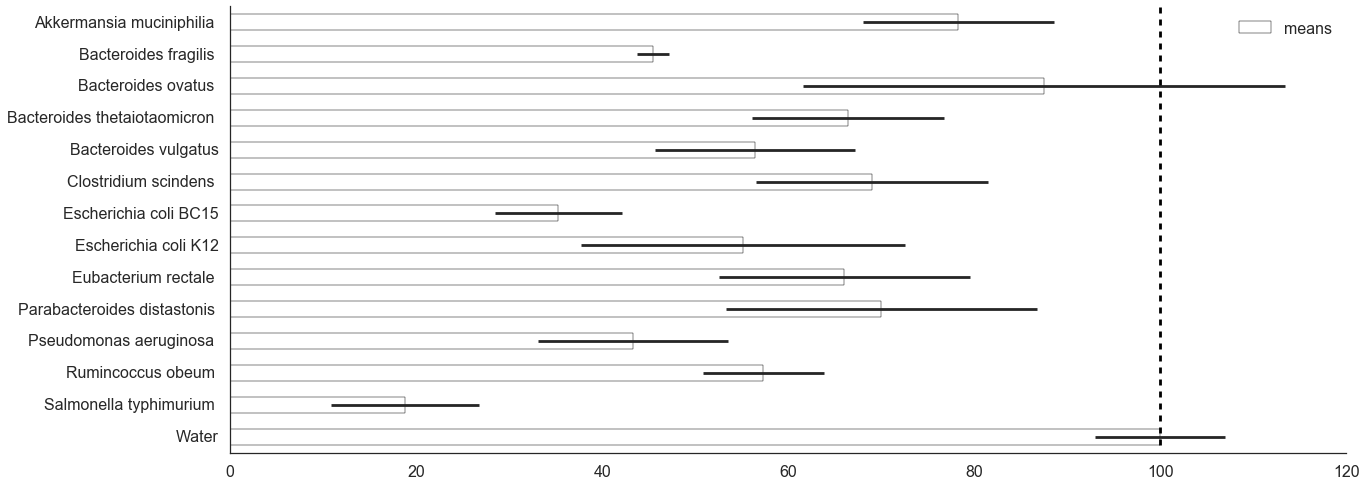

In [251]:
means = data.groupby('Indices').mean()['Normalized % GFP']
ci_width = data.groupby('Indices').std()['Normalized % GFP'] / np.sqrt(4)

freq_df = pd.DataFrame()
freq_df['means'] = data.groupby('Indices').mean()['Normalized % GFP']
freq_df['std'] = data.groupby('Indices').std()['Normalized % GFP']
freq_df['ci'] = freq_df['std'] / np.sqrt(4) * 1.96
freq_df.reset_index(inplace=True)
freq_df['Indices'] = np.abs(freq_df['Indices'] - len(freq_df)+1)
freq_df.sort('Indices').plot(kind='barh', x='Indices', y='means', xerr='ci', color='white', figsize=(20,8))

ax = plt.gca()
ax.set_yticklabels(sorted(sample_names, reverse=True))
ax.set_ylabel('')
ax.vlines(x=100, ymin=0-0.25, ymax=len(sample_names)-0.25, linestyle='--')

sns.despine()

plt.savefig('../figures/bandoro-microbiome-frequentist.pdf', bbox_inches='tight')

In [252]:
data.groupby('Sample').mean().sort('Normalized % GFP', ascending=False)

,% GFP,Normalized % GFP,Replicate,Indices
Sample,,,,
Water,20.0750,100.000000,2.5,13.0
Bacteroides ovatus,18.4425,87.525871,2.5,2.0
Akkermansia muciniphilia,15.9250,78.277791,2.5,0.0
Parabacteroides distastonis,14.6250,70.003415,2.5,9.0
Clostridium scindens,13.8875,68.996463,2.5,5.0
Bacteroides thetaiotaomicron,13.6750,66.386376,2.5,3.0
Eubacterium rectale,13.7150,66.034047,2.5,8.0
Rumincoccus obeum,11.6550,57.312946,2.5,11.0
Bacteroides vulgatus,11.6775,56.403161,2.5,4.0


In [253]:
means = trace['fold'].mean(axis=0)
mean_df = pd.DataFrame()
mean_df['means'] = means
mean_df['sample'] = sample_names
mean_df.sort('means', ascending=False)

,means,sample
13,98.056216,Rumincoccus obeum
2,83.891927,Salmonella typhimurium
0,77.579663,Bacteroides ovatus
9,69.410362,Bacteroides fragilis
5,68.877640,Bacteroides vulgatus
3,66.098399,Water
8,65.765990,Eubacterium rectale
11,57.041303,Clostridium scindens
4,56.487661,Parabacteroides distastonis
7,55.172223,Akkermansia muciniphilia


In [254]:
freq_width = freq_df['ci'] * 2
data_range = data.groupby('Indices')['Normalized % GFP'].max() - data.groupby('Indices')['Normalized % GFP'].min()
bayes_low, bayes_high = np.percentile(trace['fold'], [2.5, 97.5], axis=0)
bayes_range = bayes_high - bayes_low

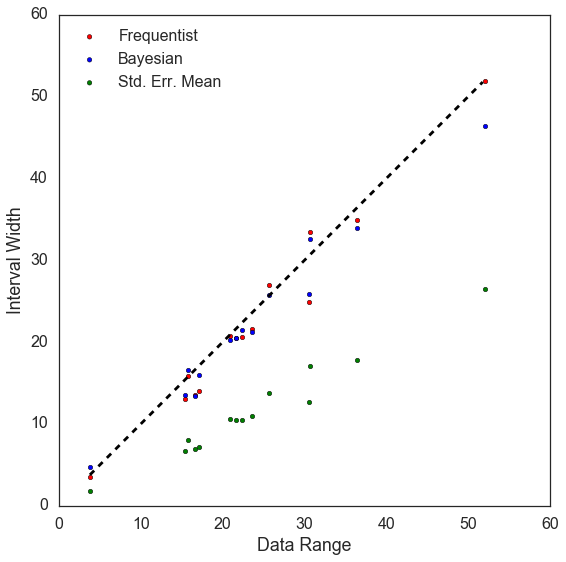

In [260]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')

range_df = pd.DataFrame()
range_df['frequentist'] = freq_width
range_df['sem'] = freq_width / 1.96
range_df['data'] = data_range
range_df['bayesian'] = bayes_range
range_df.plot(kind='scatter', x='data', y='frequentist', ax=ax, color='red', label='Frequentist')
range_df.plot(kind='scatter', x='data', y='bayesian', ax=ax, color='blue', label='Bayesian')
range_df.plot(kind='scatter', x='data', y='sem', ax=ax, color='green', label='Std. Err. Mean')
plt.plot(np.arange(min(range_df['data']), max(range_df['data'])), np.arange(min(range_df['data']), max(range_df['data'])), color='black', linestyle='--')
plt.ylabel('Interval Width')
plt.xlabel('Data Range')
plt.ylim(ax.get_xlim())


plt.savefig('../figures/range-estimates.pdf', bbox_inches='tight')